# CycleGAN图像风格迁移互换

> 本案例运行需要较大内存，建议在Ascend/GPU上运行。


## 模型介绍

### 模型简介

CycleGAN(Cycle Generative Adversarial Network) 即循环对抗生成网络，来自论文 [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593) 。该模型实现了一种在没有配对示例的情况下学习将图像从源域 X 转换到目标域 Y 的方法。

该模型一个重要应用领域是域迁移(Domain Adaptation)，可以通俗地理解为图像风格迁移。其实在 CycleGAN 之前，就已经有了域迁移模型，比如 Pix2Pix ，但是 Pix2Pix 要求训练数据必须是成对的，而现实生活中，要找到两个域（画风）中成对出现的图片是相当困难的，因此 CycleGAN 诞生了，它只需要两种域的数据，而不需要他们有严格对应关系，是一种新的无监督的图像迁移网络。


### 模型结构

CycleGAN 网络本质上是由两个镜像对称的 GAN 网络组成，其结构如下图所示（图片来源于原论文）：

![CycleGAN](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.10/tutorials/source_zh_cn/generative/images/CycleGAN.png)

为了方便理解，这里以苹果和橘子为例介绍。上图中 $X$ 可以理解为苹果，$Y$ 为橘子；$G$ 为将苹果生成橘子风格的生成器，$F$ 为将橘子生成的苹果风格的生成器，$D_{X}$ 和 $D_{Y}$ 为其相应判别器，具体生成器和判别器的结构可见下文代码。模型最终能够输出两个模型的权重，分别将两种图像的风格进行彼此迁移，生成新的图像。

该模型一个很重要的部分就是损失函数，在所有损失里面循环一致损失(Cycle Consistency Loss)是最重要的。循环损失的计算过程如下图所示（图片来源于原论文）：

![Cycle Consistency Loss](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.10/tutorials/source_zh_cn/generative/images/CycleGAN_1.png)

图中苹果图片 $x$ 经过生成器 $G$ 得到伪橘子 $\hat{Y}$，然后将伪橘子 $\hat{Y}$ 结果送进生成器 $F$ 又产生苹果风格的结果 $\hat{x}$，最后将生成的苹果风格结果 $\hat{x}$ 与原苹果图片 $x$ 一起计算出循环一致损失，反之亦然。循环损失捕捉了这样的直觉，即如果我们从一个域转换到另一个域，然后再转换回来，我们应该到达我们开始的地方。详细的训练过程见下文代码。


## 数据集

本案例使用的数据集里面的图片来源于[ImageNet](https://ieeexplore.ieee.org/document/5206848)，该数据集共有17个数据包，本文只使用了其中的苹果橘子部分。图像被统一缩放为256×256像素大小，其中用于训练的苹果图片996张、橘子图片1020张，用于测试的苹果图片266张、橘子图片248张。

这里对数据进行了随机裁剪、水平随机翻转和归一化的预处理，为了将重点聚焦到模型，此处将数据预处理后的结果转换为 MindRecord 格式的数据，以省略大部分数据预处理的代码。

### 数据集下载

使用 `download` 接口下载数据集，并将下载后的数据集自动解压到当前目录下。数据下载之前需要使用 `pip install download` 安装 `download` 包。


In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.4.10，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.4.10
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/x86_64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.4.10
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


In [3]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/models/application/CycleGAN_apple2orange.zip"

download(url, ".", kind="zip", replace=True)


file_sizes: 100%|█████████████████████████████| 489M/489M [00:02<00:00, 172MB/s]
Extracting zip file...
Successfully downloaded / unzipped to .


'.'

### 数据集加载

使用 MindSpore 的 `MindDataset` 接口读取和解析数据集。


In [4]:
from mindspore.dataset import MindDataset

# 读取MindRecord格式数据
name_mr = "./CycleGAN_apple2orange/apple2orange_train.mindrecord"
data = MindDataset(dataset_files=name_mr,num_samples=10)
print("Datasize: ", data.get_dataset_size())

batch_size = 1
dataset = data.batch(batch_size)
datasize = dataset.get_dataset_size()

Datasize:  10


### 可视化

通过 `create_dict_iterator` 函数将数据转换成字典迭代器，然后使用 `matplotlib` 模块可视化部分训练数据。


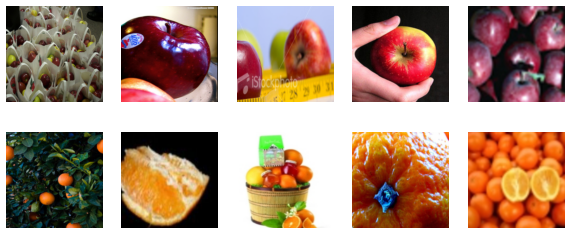

In [5]:
import numpy as np
import matplotlib.pyplot as plt

mean = 0.5 * 255
std = 0.5 * 255

plt.figure(figsize=(12, 5), dpi=60)
for i, data in enumerate(dataset.create_dict_iterator()):
    if i < 5:
        show_images_a = data["image_A"].asnumpy()
        show_images_b = data["image_B"].asnumpy()

        plt.subplot(2, 5, i+1)
        show_images_a = (show_images_a[0] * std + mean).astype(np.uint8).transpose((1, 2, 0))
        plt.imshow(show_images_a)
        plt.axis("off")

        plt.subplot(2, 5, i+6)
        show_images_b = (show_images_b[0] * std + mean).astype(np.uint8).transpose((1, 2, 0))
        plt.imshow(show_images_b)
        plt.axis("off")
    else:
        break
plt.show()

## 构建生成器

本案例生成器的模型结构参考的 ResNet 模型的结构，参考原论文，对于128×128大小的输入图片采用6个残差块相连，图片大小为256×256以上的需要采用9个残差块相连，所以本文网络有9个残差块相连，超参数 `n_layers` 参数控制残差块数。

生成器的结构如下所示：

![CycleGAN Generator](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.10/tutorials/source_zh_cn/generative/images/CycleGAN_2.jpg)

具体的模型结构请参照下文代码：


In [6]:
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore.common.initializer import Normal

weight_init = Normal(sigma=0.02)

class ConvNormReLU(nn.Cell):
    def __init__(self, input_channel, out_planes, kernel_size=4, stride=2, alpha=0.2, norm_mode='instance',
                 pad_mode='CONSTANT', use_relu=True, padding=None, transpose=False):
        super(ConvNormReLU, self).__init__()
        norm = nn.BatchNorm2d(out_planes)
        if norm_mode == 'instance':
            norm = nn.BatchNorm2d(out_planes, affine=False)
        has_bias = (norm_mode == 'instance')
        if padding is None:
            padding = (kernel_size - 1) // 2
        if pad_mode == 'CONSTANT':
            if transpose:
                conv = nn.Conv2dTranspose(input_channel, out_planes, kernel_size, stride, pad_mode='same',
                                          has_bias=has_bias, weight_init=weight_init)
            else:
                conv = nn.Conv2d(input_channel, out_planes, kernel_size, stride, pad_mode='pad',
                                 has_bias=has_bias, padding=padding, weight_init=weight_init)
            layers = [conv, norm]
        else:
            paddings = ((0, 0), (0, 0), (padding, padding), (padding, padding))
            pad = nn.Pad(paddings=paddings, mode=pad_mode)
            if transpose:
                conv = nn.Conv2dTranspose(input_channel, out_planes, kernel_size, stride, pad_mode='pad',
                                          has_bias=has_bias, weight_init=weight_init)
            else:
                conv = nn.Conv2d(input_channel, out_planes, kernel_size, stride, pad_mode='pad',
                                 has_bias=has_bias, weight_init=weight_init)
            layers = [pad, conv, norm]
        if use_relu:
            relu = nn.ReLU()
            if alpha > 0:
                relu = nn.LeakyReLU(alpha)
            layers.append(relu)
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output


class ResidualBlock(nn.Cell):
    def __init__(self, dim, norm_mode='instance', dropout=False, pad_mode="CONSTANT"):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvNormReLU(dim, dim, 3, 1, 0, norm_mode, pad_mode)
        self.conv2 = ConvNormReLU(dim, dim, 3, 1, 0, norm_mode, pad_mode, use_relu=False)
        self.dropout = dropout
        if dropout:
            self.dropout = nn.Dropout(p=0.5)

    def construct(self, x):
        out = self.conv1(x)
        if self.dropout:
            out = self.dropout(out)
        out = self.conv2(out)
        return x + out


class ResNetGenerator(nn.Cell):
    def __init__(self, input_channel=3, output_channel=64, n_layers=9, alpha=0.2, norm_mode='instance', dropout=False,
                 pad_mode="CONSTANT"):
        super(ResNetGenerator, self).__init__()
        self.conv_in = ConvNormReLU(input_channel, output_channel, 7, 1, alpha, norm_mode, pad_mode=pad_mode)
        self.down_1 = ConvNormReLU(output_channel, output_channel * 2, 3, 2, alpha, norm_mode)
        self.down_2 = ConvNormReLU(output_channel * 2, output_channel * 4, 3, 2, alpha, norm_mode)
        layers = [ResidualBlock(output_channel * 4, norm_mode, dropout=dropout, pad_mode=pad_mode)] * n_layers
        self.residuals = nn.SequentialCell(layers)
        self.up_2 = ConvNormReLU(output_channel * 4, output_channel * 2, 3, 2, alpha, norm_mode, transpose=True)
        self.up_1 = ConvNormReLU(output_channel * 2, output_channel, 3, 2, alpha, norm_mode, transpose=True)
        if pad_mode == "CONSTANT":
            self.conv_out = nn.Conv2d(output_channel, 3, kernel_size=7, stride=1, pad_mode='pad',
                                      padding=3, weight_init=weight_init)
        else:
            pad = nn.Pad(paddings=((0, 0), (0, 0), (3, 3), (3, 3)), mode=pad_mode)
            conv = nn.Conv2d(output_channel, 3, kernel_size=7, stride=1, pad_mode='pad', weight_init=weight_init)
            self.conv_out = nn.SequentialCell([pad, conv])

    def construct(self, x):
        x = self.conv_in(x)
        x = self.down_1(x)
        x = self.down_2(x)
        x = self.residuals(x)
        x = self.up_2(x)
        x = self.up_1(x)
        output = self.conv_out(x)
        return ops.tanh(output)

# 实例化生成器
net_rg_a = ResNetGenerator()
net_rg_a.update_parameters_name('net_rg_a.')

net_rg_b = ResNetGenerator()
net_rg_b.update_parameters_name('net_rg_b.')


## 构建判别器

判别器其实是一个二分类网络模型，输出判定该图像为真实图的概率。网络模型使用的是 Patch 大小为 70x70 的 PatchGANs 模型。通过一系列的 `Conv2d` 、 `BatchNorm2d` 和 `LeakyReLU` 层对其进行处理，最后通过 Sigmoid 激活函数得到最终概率。


In [7]:
# 定义判别器
class Discriminator(nn.Cell):
    def __init__(self, input_channel=3, output_channel=64, n_layers=3, alpha=0.2, norm_mode='instance'):
        super(Discriminator, self).__init__()
        kernel_size = 4
        layers = [nn.Conv2d(input_channel, output_channel, kernel_size, 2, pad_mode='pad', padding=1, weight_init=weight_init),
                  nn.LeakyReLU(alpha)]
        nf_mult = output_channel
        for i in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** i, 8) * output_channel
            layers.append(ConvNormReLU(nf_mult_prev, nf_mult, kernel_size, 2, alpha, norm_mode, padding=1))
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8) * output_channel
        layers.append(ConvNormReLU(nf_mult_prev, nf_mult, kernel_size, 1, alpha, norm_mode, padding=1))
        layers.append(nn.Conv2d(nf_mult, 1, kernel_size, 1, pad_mode='pad', padding=1, weight_init=weight_init))
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output

# 判别器初始化
net_d_a = Discriminator()
net_d_a.update_parameters_name('net_d_a.')

net_d_b = Discriminator()
net_d_b.update_parameters_name('net_d_b.')


## 优化器和损失函数

根据不同模型需要单独的设置优化器，这是训练过程决定的。

对生成器 $G$ 及其判别器 $D_{Y}$ ，目标损失函数定义为:

$$L_{GAN}(G,D_Y,X,Y)=E_{y-p_{data}(y)}[logD_Y(y)]+E_{x-p_{data}(x)}[log(1-D_Y(G(x)))]$$

其中 $G$ 试图生成看起来与 $Y$ 中的图像相似的图像 $G(x)$ ，而 $D_{Y}$ 的目标是区分翻译样本 $G(x)$ 和真实样本 $y$ ，生成器的目标是最小化这个损失函数以此来对抗判别器。即 $ min_{G} max_{D_{Y}}L_{GAN}(G,D_{Y} ,X,Y )$ 。

单独的对抗损失不能保证所学函数可以将单个输入映射到期望的输出，为了进一步减少可能的映射函数的空间，学习到的映射函数应该是周期一致的，例如对于 $X$ 的每个图像 $x$ ，图像转换周期应能够将 $x$ 带回原始图像，可以称之为正向循环一致性，即 $x→G(x)→F(G(x))\approx x$ 。对于 $Y$ ，类似的 $x→G(x)→F(G(x))\approx x$ 。可以理解采用了一个循环一致性损失来激励这种行为。

循环一致损失函数定义如下：

$$L_{cyc}(G,F)=E_{x-p_{data}(x)}[\Vert F(G(x))-x\Vert_{1}]+E_{y-p_{data}(y)}[\Vert G(F(y))-y\Vert_{1}]$$

循环一致损失能够保证重建图像 $F(G(x))$ 与输入图像 $x$ 紧密匹配。


In [8]:
# 构建生成器，判别器优化器
optimizer_rg_a = nn.Adam(net_rg_a.trainable_params(), learning_rate=0.0002, beta1=0.5)
optimizer_rg_b = nn.Adam(net_rg_b.trainable_params(), learning_rate=0.0002, beta1=0.5)

optimizer_d_a = nn.Adam(net_d_a.trainable_params(), learning_rate=0.0002, beta1=0.5)
optimizer_d_b = nn.Adam(net_d_b.trainable_params(), learning_rate=0.0002, beta1=0.5)

# GAN网络损失函数，这里最后一层不使用sigmoid函数
loss_fn = nn.MSELoss(reduction='mean')
l1_loss = nn.L1Loss("mean")

def gan_loss(predict, target):
    target = ops.ones_like(predict) * target
    loss = loss_fn(predict, target)
    return loss


## 前向计算

搭建模型前向计算损失的过程，过程如下代码。

为了减少模型振荡[1]，这里遵循 Shrivastava 等人的策略[2]，使用生成器生成图像的历史数据而不是生成器生成的最新图像数据来更新鉴别器。这里创建 `image_pool` 函数，保留了一个图像缓冲区，用于存储生成器生成前的50个图像。


In [9]:
import mindspore as ms

# 前向计算

def generator(img_a, img_b):
    fake_a = net_rg_b(img_b)
    fake_b = net_rg_a(img_a)
    rec_a = net_rg_b(fake_b)
    rec_b = net_rg_a(fake_a)
    identity_a = net_rg_b(img_a)
    identity_b = net_rg_a(img_b)
    return fake_a, fake_b, rec_a, rec_b, identity_a, identity_b

lambda_a = 10.0
lambda_b = 10.0
lambda_idt = 0.5

def generator_forward(img_a, img_b):
    true = Tensor(True, dtype.bool_)
    fake_a, fake_b, rec_a, rec_b, identity_a, identity_b = generator(img_a, img_b)
    loss_g_a = gan_loss(net_d_b(fake_b), true)
    loss_g_b = gan_loss(net_d_a(fake_a), true)
    loss_c_a = l1_loss(rec_a, img_a) * lambda_a
    loss_c_b = l1_loss(rec_b, img_b) * lambda_b
    loss_idt_a = l1_loss(identity_a, img_a) * lambda_a * lambda_idt
    loss_idt_b = l1_loss(identity_b, img_b) * lambda_b * lambda_idt
    loss_g = loss_g_a + loss_g_b + loss_c_a + loss_c_b + loss_idt_a + loss_idt_b
    return fake_a, fake_b, loss_g, loss_g_a, loss_g_b, loss_c_a, loss_c_b, loss_idt_a, loss_idt_b

def generator_forward_grad(img_a, img_b):
    _, _, loss_g, _, _, _, _, _, _ = generator_forward(img_a, img_b)
    return loss_g

def discriminator_forward(img_a, img_b, fake_a, fake_b):
    false = Tensor(False, dtype.bool_)
    true = Tensor(True, dtype.bool_)
    d_fake_a = net_d_a(fake_a)
    d_img_a = net_d_a(img_a)
    d_fake_b = net_d_b(fake_b)
    d_img_b = net_d_b(img_b)
    loss_d_a = gan_loss(d_fake_a, false) + gan_loss(d_img_a, true)
    loss_d_b = gan_loss(d_fake_b, false) + gan_loss(d_img_b, true)
    loss_d = (loss_d_a + loss_d_b) * 0.5
    return loss_d

def discriminator_forward_a(img_a, fake_a):
    false = Tensor(False, dtype.bool_)
    true = Tensor(True, dtype.bool_)
    d_fake_a = net_d_a(fake_a)
    d_img_a = net_d_a(img_a)
    loss_d_a = gan_loss(d_fake_a, false) + gan_loss(d_img_a, true)
    return loss_d_a

def discriminator_forward_b(img_b, fake_b):
    false = Tensor(False, dtype.bool_)
    true = Tensor(True, dtype.bool_)
    d_fake_b = net_d_b(fake_b)
    d_img_b = net_d_b(img_b)
    loss_d_b = gan_loss(d_fake_b, false) + gan_loss(d_img_b, true)
    return loss_d_b

# 保留了一个图像缓冲区，用来存储之前创建的50个图像
pool_size = 50
def image_pool(images):
    num_imgs = 0
    image1 = []
    if isinstance(images, Tensor):
        images = images.asnumpy()
    return_images = []
    for image in images:
        if num_imgs < pool_size:
            num_imgs = num_imgs + 1
            image1.append(image)
            return_images.append(image)
        else:
            if random.uniform(0, 1) > 0.5:
                random_id = random.randint(0, pool_size - 1)

                tmp = image1[random_id].copy()
                image1[random_id] = image
                return_images.append(tmp)

            else:
                return_images.append(image)
    output = Tensor(return_images, ms.float32)
    if output.ndim != 4:
        raise ValueError("img should be 4d, but get shape {}".format(output.shape))
    return output


## 计算梯度和反向传播

其中梯度计算也是分开不同的模型来进行的，详情见如下代码：

In [10]:
from mindspore import value_and_grad

# 实例化求梯度的方法
grad_g_a = value_and_grad(generator_forward_grad, None, net_rg_a.trainable_params())
grad_g_b = value_and_grad(generator_forward_grad, None, net_rg_b.trainable_params())

grad_d_a = value_and_grad(discriminator_forward_a, None, net_d_a.trainable_params())
grad_d_b = value_and_grad(discriminator_forward_b, None, net_d_b.trainable_params())

# 计算生成器的梯度，反向传播更新参数
def train_step_g(img_a, img_b):
    net_d_a.set_grad(False)
    net_d_b.set_grad(False)

    fake_a, fake_b, lg, lga, lgb, lca, lcb, lia, lib = generator_forward(img_a, img_b)

    _, grads_g_a = grad_g_a(img_a, img_b)
    _, grads_g_b = grad_g_b(img_a, img_b)
    optimizer_rg_a(grads_g_a)
    optimizer_rg_b(grads_g_b)

    return fake_a, fake_b, lg, lga, lgb, lca, lcb, lia, lib

# 计算判别器的梯度，反向传播更新参数
def train_step_d(img_a, img_b, fake_a, fake_b):
    net_d_a.set_grad(True)
    net_d_b.set_grad(True)

    loss_d_a, grads_d_a = grad_d_a(img_a, fake_a)
    loss_d_b, grads_d_b = grad_d_b(img_b, fake_b)

    loss_d = (loss_d_a + loss_d_b) * 0.5

    optimizer_d_a(grads_d_a)
    optimizer_d_b(grads_d_b)

    return loss_d


## 模型训练

训练分为两个主要部分：训练判别器和训练生成器，在前文的判别器损失函数中，论文采用了最小二乘损失代替负对数似然目标。

- 训练判别器：训练判别器的目的是最大程度地提高判别图像真伪的概率。按照论文的方法需要训练判别器来最小化 $E_{y-p_{data}(y)}[(D(y)-1)^2]$ ；

- 训练生成器：如 CycleGAN 论文所述，我们希望通过最小化 $E_{x-p_{data}(x)}[(D(G(x)-1)^2]$ 来训练生成器，以产生更好的虚假图像。

下面定义了生成器和判别器的训练过程：
PS: 虽然 在线CPU环境 对部分超参已进行了调整，但是训练可能仍存在内存不足 or 空间不足的情况，建议在Ascend/GPU 环境下执行以下代码

In [11]:
import os
import time
import random
import numpy as np
from PIL import Image
from mindspore import Tensor, save_checkpoint
from mindspore import dtype

epochs = 1
save_step_num = 80
save_checkpoint_epochs = 1
save_ckpt_dir = './train_ckpt_outputs/'

# 以下是模型训练示例代码参考，建议在 CPU 环境直接进行下一步模型评估和推理，在线 CPU 环境可能无法支撑训练 (评估的是已经训练好的权重文件)
# print('Start training!')
# 
# for epoch in range(epochs):
#     g_loss = []
#     d_loss = []
#     start_time_e = time.time()
#     for step, data in enumerate(dataset.create_dict_iterator()):
#         start_time_s = time.time()
#         img_a = data["image_A"]
#         img_b = data["image_B"]
#         res_g = train_step_g(img_a, img_b)
#         fake_a = res_g[0]
#         fake_b = res_g[1]
# 
#         res_d = train_step_d(img_a, img_b, image_pool(fake_a), image_pool(fake_b))
#         loss_d = float(res_d.asnumpy())
#         step_time = time.time() - start_time_s
# 
#         res = []
#         for item in res_g[2:]:
#             res.append(float(item.asnumpy()))
#         g_loss.append(res[0])
#         d_loss.append(loss_d)
# 
#         if step % save_step_num == 0:
#             print(f"Epoch:[{int(epoch + 1):>3d}/{int(epochs):>3d}], "
#                   f"step:[{int(step):>4d}/{int(datasize):>4d}], "
#                   f"time:{step_time:>3f}s,\n"
#                   f"loss_g:{res[0]:.2f}, loss_d:{loss_d:.2f}, "
#                   f"loss_g_a: {res[1]:.2f}, loss_g_b: {res[2]:.2f}, "
#                   f"loss_c_a: {res[3]:.2f}, loss_c_b: {res[4]:.2f}, "
#                   f"loss_idt_a: {res[5]:.2f}, loss_idt_b: {res[6]:.2f}")
# 
#     epoch_cost = time.time() - start_time_e
#     per_step_time = epoch_cost / datasize
#     mean_loss_d, mean_loss_g = sum(d_loss) / datasize, sum(g_loss) / datasize
# 
#     print(f"Epoch:[{int(epoch + 1):>3d}/{int(epochs):>3d}], "
#           f"epoch time:{epoch_cost:.2f}s, per step time:{per_step_time:.2f}, "
#           f"mean_g_loss:{mean_loss_g:.2f}, mean_d_loss:{mean_loss_d :.2f}")
# 
#     if epoch % save_checkpoint_epochs == 0:
#         os.makedirs(save_ckpt_dir, exist_ok=True)
#         save_checkpoint(net_rg_a, os.path.join(save_ckpt_dir, f"g_a_{epoch}.ckpt"))
#         save_checkpoint(net_rg_b, os.path.join(save_ckpt_dir, f"g_b_{epoch}.ckpt"))
#         save_checkpoint(net_d_a, os.path.join(save_ckpt_dir, f"d_a_{epoch}.ckpt"))
#         save_checkpoint(net_d_b, os.path.join(save_ckpt_dir, f"d_b_{epoch}.ckpt"))
# 
# print('End of training!')

## 模型推理

下面我们通过加载生成器网络模型参数文件来对原图进行风格迁移，结果中第一行为原图，第二行为对应生成的结果图。

推理


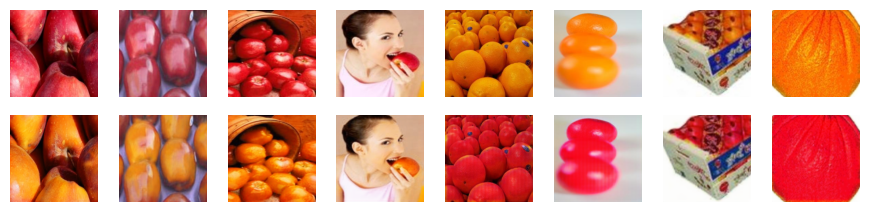

In [12]:
import os
from PIL import Image
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from mindspore import load_checkpoint, load_param_into_net

# 加载权重文件
def load_ckpt(net, ckpt_dir):
    param_GA = load_checkpoint(ckpt_dir)
    load_param_into_net(net, param_GA)

g_a_ckpt = './CycleGAN_apple2orange/ckpt/g_a.ckpt'
g_b_ckpt = './CycleGAN_apple2orange/ckpt/g_b.ckpt'

load_ckpt(net_rg_a, g_a_ckpt)
load_ckpt(net_rg_b, g_b_ckpt)

# 图片推理
fig = plt.figure(figsize=(11, 2.5), dpi=100)
def eval_data(dir_path, net, a):

    def read_img():
        for dir in os.listdir(dir_path):
            path = os.path.join(dir_path, dir)
            img = Image.open(path).convert('RGB')
            yield img, dir

    dataset = ds.GeneratorDataset(read_img, column_names=["image", "image_name"])
    trans = [vision.Resize((256, 256)), vision.Normalize(mean=[0.5 * 255] * 3, std=[0.5 * 255] * 3), vision.HWC2CHW()]
    dataset = dataset.map(operations=trans, input_columns=["image"])
    dataset = dataset.batch(1)
    for i, data in enumerate(dataset.create_dict_iterator()):
        img = data["image"]
        fake = net(img)
        fake = (fake[0] * 0.5 * 255 + 0.5 * 255).astype(np.uint8).transpose((1, 2, 0))
        img = (img[0] * 0.5 * 255 + 0.5 * 255).astype(np.uint8).transpose((1, 2, 0))

        fig.add_subplot(2, 8, i+1+a)
        plt.axis("off")
        plt.imshow(img.asnumpy())

        fig.add_subplot(2, 8, i+9+a)
        plt.axis("off")
        plt.imshow(fake.asnumpy())
print("推理")
eval_data('./CycleGAN_apple2orange/predict/apple', net_rg_a, 0)
eval_data('./CycleGAN_apple2orange/predict/orange', net_rg_b, 4)
plt.show()


## 参考

[1] I. Goodfellow. NIPS 2016 tutorial: Generative ad-versarial networks. arXiv preprint arXiv:1701.00160,2016. 2, 4, 5

[2] A. Shrivastava, T. Pfister, O. Tuzel, J. Susskind, W. Wang, R. Webb. Learning from simulated and unsupervised images through adversarial training. In CVPR, 2017. 3, 5, 6, 7